## Problem Set #3
MACS 30100, Dr. Evans 

Shuting Chen 

In [65]:
# Import useful packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt
import scipy.integrate as intgr
import numpy.linalg as lin

%matplotlib inline

### 1. Some income data, lognormal distribution, and GMM

In [66]:
# Import data 
incomes = np.loadtxt('incomes.txt')

#### Part (a). Plot a histogram for the given data 

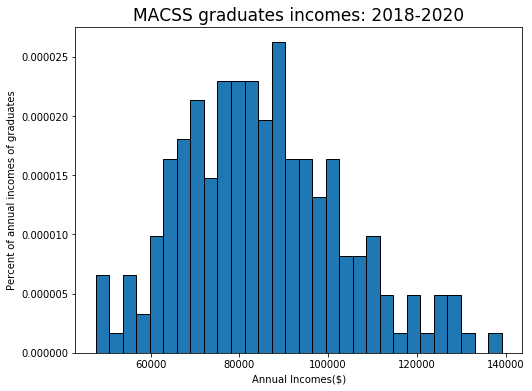

In [67]:
plt.figure(figsize=(8,6))
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, normed = True, histtype='bar', ec='black')
plt.title('MACSS graduates incomes: 2018-2020', fontsize=17)
plt.xlabel('Annual Incomes($)')
plt.ylabel('Percent of annual incomes of graduates')
plt.show()

#### Part (b).  Estimate the parameters of the lognormal distribution by GMM

In [68]:
def log_norm_pdf(xvals, mu, sigma):
    '''
    ----------------------------------------------------------------------
    Generate pdf values from the lognormal pdf with mean mu and standard
    deviation sigma. 
    ----------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the log-normally distributed random
             variable
    mu     = scalar, mean of the log-normally distributed random variable
    sigma  = scalar > 0, standard deviation of the log-normally 
             distributed random variable

    RETURNS: pdf_vals
    ----------------------------------------------------------------------
    '''
    pdf_vals = (1/(xvals * sigma * np.sqrt(2 * np.pi))) *\
                np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))    
    
    return pdf_vals

def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, incomes data
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of incomes data
    var_data  = scalar > 0, variance of incomes data
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data


def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    #xfx = lambda x: x * log_norm_pdf(x, mu, sigma)
    #(mean_model, m_m_err) = intgr.quad(xfx, 1e-30, 150000)
    #x2fx = lambda x: ((x - mean_model) ** 2) * log_norm_pdf(x, mu, sigma) 
    #(var_model, v_m_err) = intgr.quad(x2fx, 1e-30, 150000)
    
    # Instead of using integration, I try to obtain mean and variance of 
    # model by the formula of mean and variance for log-normal distribution
    
    mean_model = np.exp(mu + sigma**2 / 2)
    var_model = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
    
    std_model = np.sqrt(var_model)
    
    return mean_model, var_model


def err_vec(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, incomes data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [69]:
# GMM estimation with identity matrix as weighting matrix 
mu_init = 11
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

# GMM estimates 
mu_GMM1, sig_GMM1 = results.x
print('The GMM estimates for mean and standard deviation of the lognormal distribution are {:.5f} and {:.5f}, respectively.'\
      .format(mu_GMM1, sig_GMM1))
# Value of GMM criterion function 
params_GMM = np.array([mu_GMM1, sig_GMM1])
crit_value = criterion(params_GMM, *gmm_args)[0][0]
print('The value of GMM criterion function at the estimated parameter values is {}.'. format(crit_value))
# Two data moments 
mean_data, var_data = data_moments(incomes)
print('Data moments: mean = {:.3f}, variance = {:.3f}'.format(mean_data, var_data))
# Two model moments 
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1)
print('Model moments: mean = {:.3f}, variance = {:.3f}'.format(mean_model, var_model))

The GMM estimates for mean and standard deviation of the lognormal distribution are 11.33188 and 0.20870, respectively.
The value of GMM criterion function at the estimated parameter values is 5.0459119865558186e-14.
Data moments: mean = 85276.824, variance = 323731572.230
Model moments: mean = 85276.810, variance = 323731624.429


Data moments vs. model moments: Since two model moments are very close to their counterparts of data moments, we can conclude that the GMM estimation works well. 

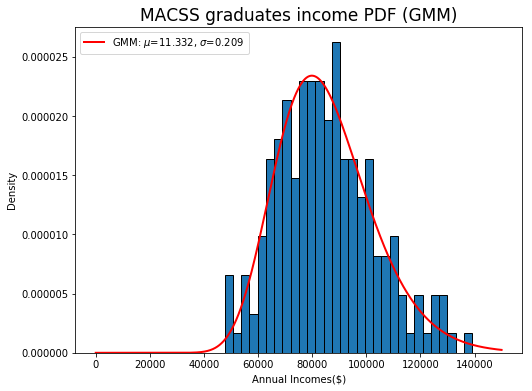

In [70]:
# Plot the estimated lognormal PDF against the histogram from part(a)
plt.figure(figsize=(8,6))
num_bins = 30
dist_pts = np.linspace(1e-10, 150000, 15000)
count, bins, ignored = plt.hist(incomes, num_bins, normed = True, histtype='bar', ec='black')
plt.title('MACSS graduates income PDF (GMM)', fontsize=17)
plt.xlabel('Annual Incomes($)')
plt.ylabel('Density')
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='r', label='GMM: $\mu$={:.3f}, $\sigma$={:.3f}'.format(
         mu_GMM1, sig_GMM1))
plt.legend(loc='upper left')
plt.show()

#### Part (c).  Perform the two-step GMM estimator

In [71]:
# Compute the vector of moment errors using GMM estimators 
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, False)
# Obtain the variance-covariance matrix based on moment errors 
VCV2 = np.dot(err1, err1.T) / incomes.shape[0]
# Get the inverse of VCV matrix 
W_hat2 = lin.pinv(VCV2) 

params_init1 = np.array([mu_GMM1, sig_GMM1])
gmm_args1 = (incomes, W_hat2)
results1 = opt.minimize(criterion, params_init1, args = (gmm_args1), 
                       method = 'L-BFGS-B', bounds = ((None, None), (1e-10, None)))

# GMM estimates 
mu_GMM2, sig_GMM2 = results1.x
print('The two-step GMM estimates for mean and standard deviation of the lognormal distribution are {:.5f} and {:.5f}, respectively.'\
      .format(mu_GMM2, sig_GMM2))
# Value of GMM criterion function 
params_GMM1 = np.array([mu_GMM2, sig_GMM2])
crit_value1 = criterion(params_GMM1, *gmm_args1)[0][0]
print('The value of GMM criterion function at the estimated parameter values is {}.'. format(crit_value1))
# Two data moments 
mean_data, var_data = data_moments(incomes)
print('Data moments: mean = {:.3f}, variance = {:.3f}'.format(mean_data, var_data))
# Two model moments 
mean_model1, var_model1 = model_moments(mu_GMM2, sig_GMM2)
print('Model moments: mean = {:.3f}, variance = {:.3f}'.format(mean_model1, var_model1))

The two-step GMM estimates for mean and standard deviation of the lognormal distribution are 11.33188 and 0.20870, respectively.
The value of GMM criterion function at the estimated parameter values is 1.1076190204843683e-06.
Data moments: mean = 85276.824, variance = 323731572.230
Model moments: mean = 85276.784, variance = 323731427.712


Data moments vs. model moments: since two data moments are quite similiar to model moments, it is reasonable to conclude that the two-step GMM estimation performs well. 

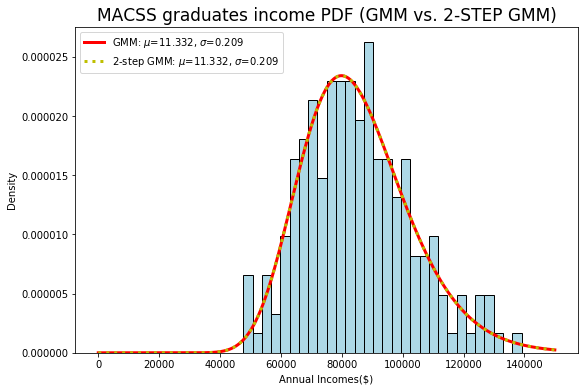

In [72]:
# Plot the estimated lognormal PDF against the histogram from part(a) and the estimated PDF from part (b)
plt.figure(figsize=(9,6))
num_bins = 30
dist_pts = np.linspace(1e-10, 150000, 15000)
count, bins, ignored = plt.hist(incomes, num_bins, normed = True, color = 'lightblue', ec='black')
plt.title('MACSS graduates income PDF (GMM vs. 2-STEP GMM)', fontsize=17)
plt.xlabel('Annual Incomes($)')
plt.ylabel('Density')
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=3, color='r', label='GMM: $\mu$={:.3f}, $\sigma$={:.3f}'.format(
         mu_GMM1, sig_GMM1))
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM2, sig_GMM2),
         linewidth=3, color='y', linestyle=':', label='2-step GMM: $\mu$={:.3f}, $\sigma$={:.3f}'.format(
         mu_GMM2, sig_GMM2))
plt.legend(loc='upper left')
plt.show()

#### Part (d). Re-estimate the lognormal PDF by GMM using different moments 

In [73]:
def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 75,000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75,000 <= x < 100,000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 100,000 <= x 

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the four model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: log_norm_pdf(x, mu, sigma)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = (1, 0) - intgr.quad(xfx, 0, 100000)* np.array([1, -1])
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (3, 1) matrix, column vector of three data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (3, 1) matrix, column vector of three model moments
    err_vec    = (3, 1) matrix, column vector of three moment error
                 functions
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the log normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (3, 1) matrix, column vector of three moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [74]:
# GMM estimation with identity matrix as weighting matrix 
mu_init = 11
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (incomes, W_hat)
results = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

# GMM estimates 
mu_GMM3, sig_GMM3 = results.x
print('The GMM estimates for mean and standard deviation of the lognormal distribution are {:.5f} and {:.5f}, respectively.'\
      .format(mu_GMM3, sig_GMM3))
# Value of GMM criterion function 
params_GMM2 = np.array([mu_GMM3, sig_GMM3])
crit_value2 = criterion3(params_GMM2, *gmm_args)[0][0]
print('The value of GMM criterion function at the estimated parameter values is {}.'. format(crit_value2))
# Three data moments 
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(incomes)
print('Data moments(percent of individuals who earn): < $75,000 = {:.3f},  [$75,000, $100,000) = {:.3f}, > $100,000 = {:.3f}'\
      .format(bpct_1_dat*100, bpct_2_dat*100, bpct_3_dat*100))
# Three model moments 
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM3, sig_GMM3)
print('Model moments(percent of individuals who earn): < $75,000 = {},  [$75,000, $100,000) = {}, > $100,000 = {}'\
      .format(bpct_1_mod*100, bpct_2_mod*100, bpct_3_mod*100))

The GMM estimates for mean and standard deviation of the lognormal distribution are 11.33568 and 0.21060, respectively.
The value of GMM criterion function at the estimated parameter values is 5.370045259027523e-12.
Data moments(percent of individuals who earn): < $75,000 = 30.000,  [$75,000, $100,000) = 50.000, > $100,000 = 20.000
Model moments(percent of individuals who earn): < $75,000 = 30.00000041892004,  [$75,000, $100,000) = 49.99999995041876, > $100,000 = 19.999999630661204


Data moments vs. model moments: since three data moments are quite similiar to model moments, it is reasonable to conclude that the GMM estimation with three different moments performs well. 

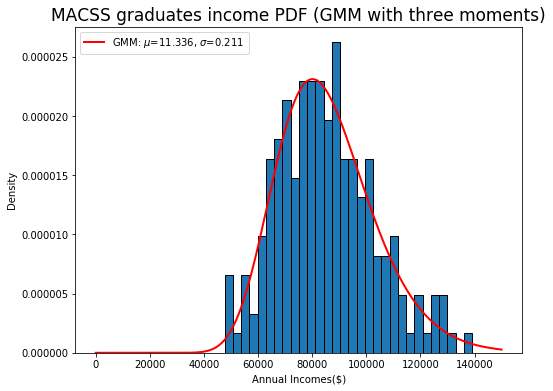

In [75]:
# Plot the estimated lognormal PDF against the histogram from part(a)
plt.figure(figsize=(8,6))
num_bins = 30
dist_pts = np.linspace(1e-10, 150000, 15000)
count, bins, ignored = plt.hist(incomes, num_bins, normed = True, histtype='bar', ec='black')
plt.title('MACSS graduates income PDF (GMM with three moments)', fontsize=17)
plt.xlabel('Annual Incomes($)')
plt.ylabel('Density')
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM3, sig_GMM3),
         linewidth=2, color='r', label='GMM: $\mu$={:.3f}, $\sigma$={:.3f}'.format(
         mu_GMM3, sig_GMM3))
plt.legend(loc='upper left')
plt.show()

#### Part (e). Perform the two-step GMM estimator by using estimates from part (d)

In [77]:
# Compute the vector of moment errors using GMM estimators 
err_3 = err_vec3(incomes, mu_GMM3, sig_GMM3, False)
# Obtain the variance-covariance matrix based on moment errors 
VCV_3 = np.dot(err_3, err_3.T) / incomes.shape[0]
# Get the inverse of VCV matrix 
W_hat_3 = lin.pinv(VCV_3) 

params_init_3 = np.array([mu_GMM3, sig_GMM3])
gmm_args_3 = (incomes, W_hat_3)
results2 = opt.minimize(criterion3, params_init_3, args = (gmm_args_3), 
                       method = 'L-BFGS-B', bounds = ((None, None), (1e-10, None)))
 
# GMM estimates 
mu_GMM4, sig_GMM4 = results2.x
print('The two-step GMM estimates for mean and standard deviation of the lognormal distribution are {:.5f} and {:.5f}, respectively.'\
      .format(mu_GMM4, sig_GMM4))
# Value of GMM criterion function 
params_GMM_3 = np.array([mu_GMM4, sig_GMM4])
crit_value_3 = criterion3(params_GMM_3, *gmm_args_3)[0][0]
print('The value of GMM criterion function at the estimated parameter values is {}.'. format(crit_value_3))
# Three data moments 
bpct_1_dat_3, bpct_2_dat_3, bpct_3_dat_3 = data_moments3(incomes)
print('Data moments(percent of individuals who earn): < $75,000 = {:.3f},  [$75,000, $100,000) = {:.3f}, > $100,000 = {:.3f}'\
      .format(bpct_1_dat_3*100, bpct_2_dat_3*100, bpct_3_dat_3*100))
# Three model moments 
bpct_1_mod_3, bpct_2_mod_3, bpct_3_mod_3 = model_moments3(mu_GMM4, sig_GMM4)
print('Model moments(percent of individuals who earn): < $75,000 = {},  [$75,000, $100,000) = {}, > $100,000 = {}'\
      .format(bpct_1_mod_3*100, bpct_2_mod_3*100, bpct_3_mod_3*100))

The two-step GMM estimates for mean and standard deviation of the lognormal distribution are 11.33568 and 0.21060, respectively.
The value of GMM criterion function at the estimated parameter values is 200.00000000000006.
Data moments(percent of individuals who earn): < $75,000 = 30.000,  [$75,000, $100,000) = 50.000, > $100,000 = 20.000
Model moments(percent of individuals who earn): < $75,000 = 30.00000041892004,  [$75,000, $100,000) = 49.99999995041876, > $100,000 = 19.999999630661204


Data moments vs. model moments: since three data moments are quite similiar to model moments, it is reasonable to conclude that the two-step GMM estimation with three different moments performs well. 

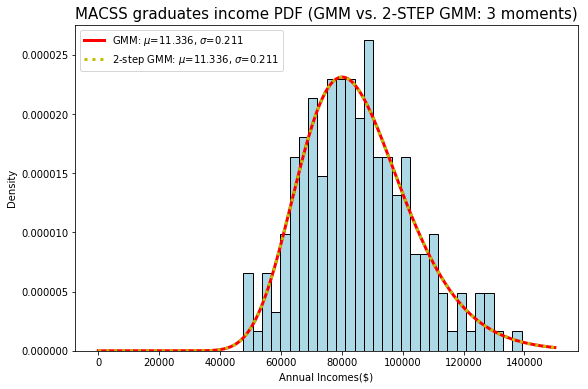

In [78]:
# Plot the estimated lognormal PDF against the histogram from part(a) and the estimated PDF from part (d)
plt.figure(figsize=(9,6))
num_bins = 30
dist_pts = np.linspace(1e-10, 150000, 15000)
count, bins, ignored = plt.hist(incomes, num_bins, normed = True, color = 'lightblue', ec='black') 
plt.title('MACSS graduates income PDF (GMM vs. 2-STEP GMM: 3 moments)', fontsize=15)
plt.xlabel('Annual Incomes($)')
plt.ylabel('Density')
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM3, sig_GMM3),
         linewidth=3, color='r', label='GMM: $\mu$={:.3f}, $\sigma$={:.3f}'.format(
         mu_GMM3, sig_GMM3))
plt.plot(dist_pts, log_norm_pdf(dist_pts, mu_GMM4, sig_GMM4),
         linewidth=3, color='y', linestyle=':', label='2-step GMM: $\mu$={:.3f}, $\sigma$={:.3f}'.format(
         mu_GMM4, sig_GMM4))
plt.legend(loc='upper left')
plt.show()

#### Part (f). Justify the best estimation

Overall, all four estimations are quite close to each other. More specifically, estimates from (b) and (c) are closer since they both use mean and standard deviation as moments, while estimates from (d) and (e) are closer because they employ percent of individuals who earn more or less some pre-determined thresholds as moments. Based on the results shown above, there is no explicit evidence whether we should use two moments or three moments. However, I would probably choose estimations from (d) and (e) since they have the number of moments greater than the number of parameters that need to be estimated. This over-identification provides more information, which  could be useful to obtain better estimates. Besides, two-step GMM estimation is theoretically preferable so I think the estimation from part (e) would fit the data best. 

### 2. Linear regression and GMM

In [79]:
# Import data 
sick = pd.read_csv('sick.txt', sep = ',', header = 0, names=['sick', 'age', 'children', 'temp'])
sick.head()

,sick,age,children,temp
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [80]:
def sick_data_moments(df):
    '''
    --------------------------------------------------------------------
    This function returns the 200 data moments for GMM
    --------------------------------------------------------------------
    INPUTS:
    df = sick dataframe
    
    RETURNS: data_moments
    --------------------------------------------------------------------
    '''
    data_moments = ()
    for sick_val in df.sick:
        data_moments = data_moments + (sick_val,)
    return data_moments


def sick_model_moments(df, *params):
    '''
    --------------------------------------------------------------------
    This function computes the 200 model moments for GMM
    --------------------------------------------------------------------
    INPUTS:
    df      = sick dataframes
    *params = 4 parameters of the model 
    
    RETURNS: (model_moments)
    --------------------------------------------------------------------
    '''
    beta0, beta1, beta2, beta3 = params
    
    model_moments = beta0 + beta1 * df.age + beta2 * df.children + \
                    beta3 * df.temp
    return (model_moments)


def sick_err_vec(df, *params):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    df      = sick dataframes
    *params = 4 parameters of the model 
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    beta0, beta1, beta2, beta3 = params

    # Compute data moments
    data_moments = sick_data_moments(df)
    moms_data = np.array(data_moments)

    # Compute model moments
    model_moments = sick_model_moments(df, beta0, beta1, beta2, beta3)
    moms_model = np.array(model_moments)

    err_vec = moms_data - moms_model

    return err_vec


def criterion_sick(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = length of 4 tuples consisting of beta0, beta1, beta2, beta3
    args   = length 2 tuple, (df, W)
    df     = the sick dataframe
    W      = (R, R) matrix, estimate of optimal weighting matrix
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    beta0, beta1, beta2, beta3 = params
    df, W = args
    err = sick_err_vec(df, beta0, beta1, beta2, beta3)
    crit_val = np.dot(np.dot(err.T, W), err)

    return crit_val


# Initialization
beta0_init = 0
beta1_init = 0
beta2_init = 0
beta3_init = 0
params_init_sick = np.array( [beta0_init, beta1_init, beta2_init, beta3_init] )
# Define weighting matrix as an identity matrix 
W_hat_sick = np.eye(200)
gmm_args_sick = (sick, W_hat_sick)
# Implement optimization 
results_sick = opt.minimize(criterion_sick, \
                            params_init_sick, \
                            args = (gmm_args_sick), \
                            method = 'L-BFGS-B', \
                            bounds = ((None, None), (None, None), \
                                      (None, None), (None, None)))
# GMM estimates 
beta0_GMM, beta1_GMM, beta2_GMM, beta3_GMM = results_sick.x
print('beta0_GMM = ', beta0_GMM)
print('beta1_GMM = ', beta1_GMM)
print('beta2_GMM = ', beta2_GMM)
print('beta3_GMM = ', beta3_GMM)
# The value of GMM criterion function
val_crit_sick = results_sick.fun
print('The value of GMM criterion function is {}.'.format(val_crit_sick))
# Data moments
data_moments_sick = sick_data_moments(sick)
# Compute model moments using GMM estimates 
model_moments_sick = sick_model_moments(sick, \
                                    beta0_GMM, beta1_GMM, beta2_GMM, beta3_GMM)


beta0_GMM =  0.251645437572
beta1_GMM =  0.0129335422436
beta2_GMM =  0.400500401025
beta3_GMM =  -0.00999176584737
The value of GMM criterion function is 0.0018212898086065973.
